# Documentation

In [1]:
from IPython.core.display import HTML
HTML("""<style>
    .MathJax_Display { font-size: 23px; }
</style>""")

$$
\theta = \theta + \alpha (r + \gamma max_{a'} Q(s',a') - Q(s,a)) \nabla_{\theta} Q(s,a)
$$

# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys


for p in ['..', '../..', '../../..', '../../../..']:
    d = os.path.abspath(p)
    if d not in sys.path:
        sys.path.insert(0,d)
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
d = [os.path.abspath('../../../../../custom_envs/gym-tiger'),
    os.path.abspath('../../../../../custom_envs/gym-dummy/')]
for _d in d:
    if _d not in sys.path:
        sys.path.insert(0, _d)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('research.neural_networks.mlp', 'ReLU')
    reload_module_by_name('research.neural_networks.mlp', 'Sigmoid')
    reload_module_by_name('research.neural_networks.mlp', 'MLPRegressor')
    reload_module_by_name(
        'experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn',
        'NumpySeqDQN')
    global ReLU, Sigmoid, MLPRegressor
    global NumpySeqDQN
    from research.neural_networks.mlp import ReLU, MLPRegressor
    from experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn \
        import NumpySeqDQN
    
    
import gym
import matplotlib.pyplot as plt
from tabulate import tabulate

from research.neural_networks.mlp import MLPRegressor, ReLU, Sigmoid
from experiments.qlearning.dqn.dqn_seq_obs.numpy_seq_dqn \
    import NumpySeqDQN, play_one, main, running_avg, plot_running_avg

# Tiger-v0

In [52]:
import gym_tiger
OBS_GROWL_LEFT = [1, 0, 0]
OBS_GROWL_RIGHT = [0, 1, 0]
OBS_START = [0, 0, 1]

ACTION_OPEN_LEFT = 0
ACTION_OPEN_RIGHT = 1
ACTION_LISTEN = 2
ACTION_MAP = {
    ACTION_OPEN_LEFT: 'OPEN_LEFT',
    ACTION_OPEN_RIGHT: 'OPEN_RIGHT',
    ACTION_LISTEN: 'LISTEN',
}

from copy import deepcopy

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1,
             max_steps_per_episode=500)
gamma = 0.99
start_obs = env.reset()

obs_seq_len = 2
hidden_layer_sizes = [5, 5]
copy_period = 25
D = obs_seq_len * env.observation_space.n
K = env.action_space.n
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-6}
model = NumpySeqDQN(D, K, hidden_layer_opts, gamma, obs_seq_len, start_obs)

N = 100
totalrewards = np.zeros(N)

obs_perms = [
    [OBS_START, OBS_START],
    [OBS_START, OBS_GROWL_LEFT],
    [OBS_START, OBS_GROWL_RIGHT],
    [OBS_GROWL_LEFT, OBS_START],
    [OBS_GROWL_LEFT, OBS_GROWL_LEFT],
    [OBS_GROWL_LEFT, OBS_GROWL_RIGHT],
    [OBS_GROWL_RIGHT, OBS_START],
    [OBS_GROWL_RIGHT, OBS_GROWL_LEFT],
    [OBS_GROWL_RIGHT, OBS_GROWL_RIGHT],
]

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
#     eps = 1/(n+1)**(1/5)
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % (N/5) == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 100):', ravg)
        Q = []
        for perm in obs_perms:
            o1, o2 = perm
            _o1 = env.translate_obs(o1)
            _o2 = env.translate_obs(o2)
            pred, _ = model.predict([o1, o2])
            best_action_idx = np.argmax(pred[0])
            action_values = pred[0].astype(str)
            action_values[best_action_idx] = action_values[best_action_idx] + ' <<'
            a_openl, a_openr, a_listen = action_values
            Q.append([_o1, _o2, a_openl, a_openr, a_listen])
        print('\n' + tabulate(Q, headers=['obs1', 'obs2', 'OPEN LEFT Q Value', 'OPEN RIGHT Q Value', 'LISTEN Q Value']))
#         display(sorted(model.train_obs_seq_counts.items(), key=lambda x: x[1], reverse=True))
#         display(sorted(model.train_obs_seq_action_counts.items(), key=lambda x: x[1], reverse=True))


print('avg reward for last 100 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: -13877 eps: 1.0 avg reward (last 100): -13877.0

obs1         obs2         OPEN LEFT Q Value        OPEN RIGHT Q Value         LISTEN Q Value
-----------  -----------  -----------------------  -----------------------  ----------------
START        START        -0.3027014638492047 <<   -0.33627432978875055            -0.699424
START        GROWL_LEFT   -0.32366965242167867     -0.3110739260492073 <<          -0.65793
START        GROWL_RIGHT  -0.3163019098500742 <<   -0.36544351948699066            -0.721439
GROWL_LEFT   START        -0.2985717827530105 <<   -0.33823471742105654            -0.699744
GROWL_LEFT   GROWL_LEFT   -0.3198142345162963      -0.3150202579526014 <<          -0.667528
GROWL_LEFT   GROWL_RIGHT  -0.31067622857053445 <<  -0.3674229403487422             -0.728395
GROWL_RIGHT  START        -0.32780860379506105     -0.32198978883400714 <<         -0.710307
GR

In [46]:
model.train_obs_seq_counts

{'GROWL_RIGHT, GROWL_RIGHT': 12340,
 'GROWL_RIGHT, GROWL_LEFT': 12369,
 'GROWL_LEFT, GROWL_RIGHT': 12600,
 'START, GROWL_RIGHT': 39,
 'GROWL_LEFT, GROWL_LEFT': 12596,
 'GROWL_RIGHT, START': 48,
 'GROWL_LEFT, START': 59,
 'START, GROWL_LEFT': 45}

In [47]:
model.train_obs_seq_action_counts

{'GROWL_RIGHT, GROWL_RIGHT => OPEN_RIGHT': 3906,
 'GROWL_RIGHT, GROWL_LEFT => LISTEN': 5090,
 'GROWL_LEFT, GROWL_RIGHT => OPEN_LEFT': 5186,
 'GROWL_RIGHT, GROWL_RIGHT => OPEN_LEFT': 5137,
 'GROWL_LEFT, GROWL_RIGHT => LISTEN': 3428,
 'START, GROWL_RIGHT => LISTEN': 14,
 'GROWL_RIGHT, GROWL_LEFT => OPEN_RIGHT': 3997,
 'GROWL_RIGHT, GROWL_RIGHT => LISTEN': 3297,
 'GROWL_LEFT, GROWL_RIGHT => OPEN_RIGHT': 3986,
 'GROWL_LEFT, GROWL_LEFT => OPEN_RIGHT': 4137,
 'GROWL_LEFT, GROWL_LEFT => LISTEN': 5098,
 'GROWL_RIGHT, GROWL_LEFT => OPEN_LEFT': 3282,
 'GROWL_LEFT, GROWL_LEFT => OPEN_LEFT': 3361,
 'GROWL_RIGHT, START => OPEN_LEFT': 12,
 'START, GROWL_RIGHT => OPEN_LEFT': 17,
 'GROWL_LEFT, START => OPEN_RIGHT': 27,
 'GROWL_RIGHT, START => LISTEN': 22,
 'GROWL_LEFT, START => LISTEN': 24,
 'START, GROWL_LEFT => OPEN_LEFT': 11,
 'GROWL_LEFT, START => OPEN_LEFT': 8,
 'START, GROWL_LEFT => OPEN_RIGHT': 12,
 'START, GROWL_RIGHT => OPEN_RIGHT': 8,
 'START, GROWL_LEFT => LISTEN': 22,
 'GROWL_RIGHT, START 

# Cartpole-v0

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: 27.0 eps: 1.0 avg reward (last 10): 27.0
episode: 10 total reward: 9.0 eps: 0.30151134457776363 avg reward (last 10): 13.454545454545455
episode: 20 total reward: 9.0 eps: 0.2182178902359924 avg reward (last 10): 11.904761904761905
episode: 30 total reward: 9.0 eps: 0.1796053020267749 avg reward (last 10): 11.419354838709678
episode: 40 total reward: 11.0 eps: 0.15617376188860607 avg reward (last 10): 11.097560975609756
episode: 50 total reward: 9.0 eps: 0.14002800840280097 avg reward (last 10): 10.901960784313726
episode: 60 total reward: 9.0 eps: 0.12803687993289598 avg reward (last 10): 10.78688524590164
episode: 70 total reward: 11.0 eps: 0.11867816581938533 avg reward (last 10): 10.67605633802817
episode: 80 total reward: 10.0 eps: 0.1111111111111111 avg reward (last 10): 

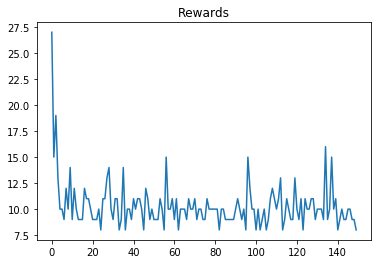

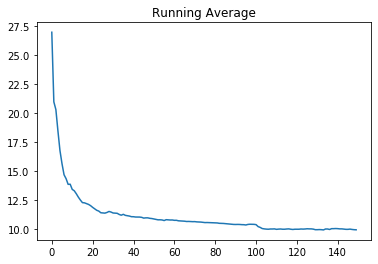

In [50]:
from copy import deepcopy

env = gym.make('CartPole-v0')
copy_period = 25
batch_size = 32
gamma = 0.99
start_obs = env.reset()
obs_seq_len = 2
D = obs_seq_len * len(env.observation_space.sample())
K = env.action_space.n
hidden_layer_sizes = [25, 50]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-2}
model = NumpySeqDQN(D, K, hidden_layer_opts, gamma, obs_seq_len, start_obs)

N = 150
totalrewards = np.zeros(N)

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma, copy_period,
                           store_seq_counts=False)
    totalrewards[n] = totalreward
    if n % 10 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
        if ravg > 150:
            break


totalrewards = totalrewards[np.where(totalrewards > 0)]
print('avg reward for last 10 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

In [ ]:
# for n in range(N):
#     eps = 1.0/np.sqrt(n+1)
# #     eps = 1/(n+1)**(1/5)
#     totalreward = play_one(env, model, eps, gamma, copy_period)
#     totalrewards[n] = totalreward
#     if n % (N/5) == 0:
#         ravg = running_avg(totalrewards, n)
#         print('episode:', n,
#               'total reward:', totalreward,
#               'eps:', eps,
#               'avg reward (last 100):', ravg)
#         Q = []
#         for perm in obs_perms:
#             o1, o2 = perm
#             _o1 = env.translate_obs(o1)
#             _o2 = env.translate_obs(o2)
#             pred, _ = model.predict([o1, o2])
#             best_action_idx = np.argmax(pred[0])
#             action_values = pred[0].astype(str)
#             action_values[best_action_idx] = action_values[best_action_idx] + ' <<'
#             a_openl, a_openr, a_listen = action_values
#             Q.append([_o1, _o2, a_openl, a_openr, a_listen])
#         print('\n' + tabulate(Q, headers=['obs1', 'obs2', 'OPEN LEFT Q Value', 'OPEN RIGHT Q Value', 'LISTEN Q Value']))
# #         display(sorted(model.train_obs_seq_counts.items(), key=lambda x: x[1], reverse=True))
# #         display(sorted(model.train_obs_seq_action_counts.items(), key=lambda x: x[1], reverse=True))


# print('avg reward for last 100 episodes:', totalrewards[-10:].mean())
# print('total steps:', totalrewards.sum())

# TwoInARow-v0

too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: 4 eps: 1.0 avg reward (last 10): 4.0
episode: 10 total reward: -10 eps: 0.30151134457776363 avg reward (last 10): -1.0909090909090908
episode: 20 total reward: 10 eps: 0.2182178902359924 avg reward (last 10): 0.0
episode: 30 total reward: 14 eps: 0.1796053020267749 avg reward (last 10): 1.6774193548387097
episode: 40 total reward: -4 eps: 0.15617376188860607 avg reward (last 10): 1.6097560975609757
episode: 50 total reward: 20 eps: 0.14002800840280097 avg reward (last 10): 0.6274509803921569
episode: 60 total reward: -6 eps: 0.12803687993289598 avg reward (last 10): 0.36065573770491804
episode: 70 total reward: -10 eps: 0.11867816581938533 avg reward (last 10): 0.39436619718309857
episode: 80 total reward: -2 eps: 0.1111111111111111 avg reward (last 10): 0.37037037037037035
episode: 90 total reward: -6 eps: 0.10482848367219183 avg reward (last 10): -0.1978021978021978
episod

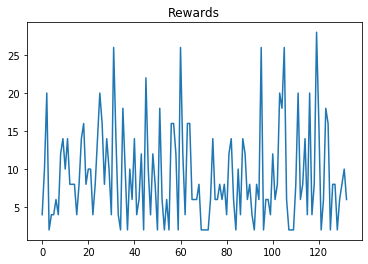

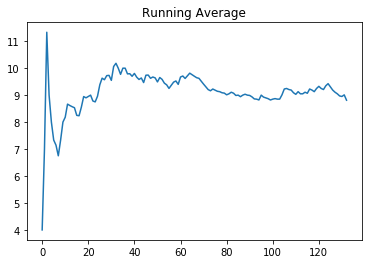

In [28]:
from copy import deepcopy
import gym_dummy

env = gym.make('TwoInARow-v0')
copy_period = 25
batch_size = 32
gamma = 0.99
start_obs = env.reset()
obs_seq_len = 2
D = obs_seq_len * 1
K = env.action_space.n
hidden_layer_sizes = [5, 5]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-2}
model = NumpySeqDQN(D, K, hidden_layer_opts, gamma, obs_seq_len, start_obs)

N = 300
totalrewards = np.zeros(N)

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma, copy_period,
                           store_seq_counts=False)
    totalrewards[n] = totalreward
    if n % 10 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)


totalrewards = totalrewards[np.where(totalrewards > 0)]
print('avg reward for last 10 episodes:', totalrewards[-10:].mean())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

In [34]:
model.predict([np.array([-1]), np.array([0])])[0]

array([[2.97360549, 3.13277623]])